# Iris Classification

## Dataset Introduction

The Iris dataset is a classic multivariate dataset collected and organized by British statistician Ronald Fisher in 1936. It contains 150 samples, each with 4 features (sepal length, sepal width, petal length, petal width) and 1 label indicating the class of the iris flower (one of three species).

We attempt to classify the Iris dataset using a simple quantum machine learning network. First, we import the necessary packages, using PyTorch as the backend.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
from sklearn import datasets, model_selection, preprocessing
from sklearn.metrics import auc, roc_curve
from torch.autograd import Variable

from isqtools import IsqCircuit
from isqtools.backend import TorchBackend
from isqtools.neural_networks import TorchLayer


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


setup_seed(217)

For the Iris dataset, we select the first two features (sepal length and sepal width) and plot a scatter diagram. It can be observed that the three different flower species show clear distinctions based on these features.

## Preliminary Visualization of the Dataset

We perform an initial visualization of the dataset by plotting the selected features. This helps us intuitively understand the distribution and separability of the data across different classes.

(1.5, 4.9)

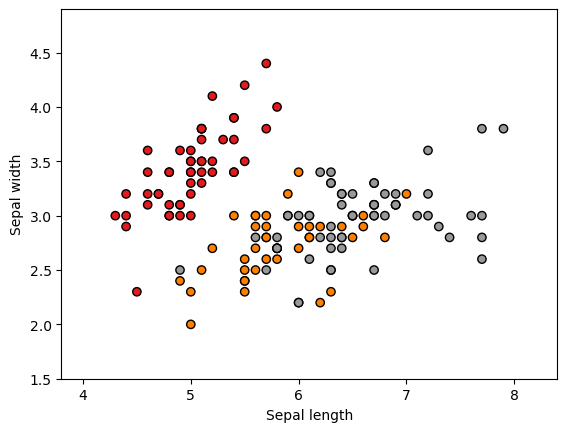

In [2]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # take the first two features
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5


# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

We officially begin using quantum machine learning methods to classify the three different species of iris flowers. First, we extract the features and corresponding labels from the dataset. We encode the features using rotation gates and apply a transformation to scale the feature values into the range (−π,π). The entire dataset is then split into a training set and a validation set.

## Data Preprocessing

In [3]:
X = iris["data"]
y = iris["target"]
names = iris["target_names"]
feature_names = iris["feature_names"]

# Scale data to have mean 0 and variance 1

scaler = preprocessing.MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

## Dataset Loading

In [4]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_scaled, y, test_size=0.2, random_state=2
)

## Build the Quantum Machine Learning Network

The `iris.isq` file defines the quantum circuit. We use `tempfile`to simulate here. For the 4 features of the iris dataset (`inputs`), we use 4 qubits and encode each feature with a rotation gate on its corresponding qubit.

We then construct a parameterized circuit using three blocks of rotation gates (`weights`). Finally, we measure the first three qubits to obtain an 8-dimensional output array, representing the states of the three measured qubits (`000`, `001`, ..., `111`).

After obtaining the measurement result, we extract 3 values from the 8-dimensional array to form a 3-dimensional output, and apply the softmax function to it.

Based on this circuit, we create the `qnn`. In addition to specifying the number of `weights` (4 layers of rotations, each with 8 weight parameters), we also enable the `vmap` method. We set `in_dims=(0, None)`, which means the first argument `inputs` is vectorized over its first dimension, while the second argument `weights` is not — this setup matches the batching behavior in neural network training.

Finally, we use the Adam optimizer and the cross-entropy loss function for training.

In [5]:
FILE_CONTENT = """\
import std;


param inputs[], weights[];
qbit q[4];

procedure single_h(qbit q[]) {
    for i in 0:q.length {
        H(q[i]);
    }
}

procedure adjacent_cz(qbit q[]) {
    for i in 0:q.length-1 {
        CZ(q[i], q[i+1]);
    }
}

procedure encode_inputs(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rz(inputs[i+start_idx], q[i]);
    }
}

procedure encode_weights(qbit q[], int start_idx) {
    for i in 0:q.length {
        Ry(weights[i+start_idx], q[i]);
    }
    for i in 0:q.length {
        Rx(weights[i+start_idx+4], q[i]);
    }
}

procedure main() {

    single_h(q);
    encode_inputs(q, 0);
    adjacent_cz(q);

    encode_weights(q, 0);
    adjacent_cz(q);

    encode_weights(q, 8);
    adjacent_cz(q);

    encode_weights(q, 16);
    adjacent_cz(q);

    encode_weights(q, 24);
    adjacent_cz(q);

    M(q[0]);
    M(q[1]);
    M(q[2]);

}"""

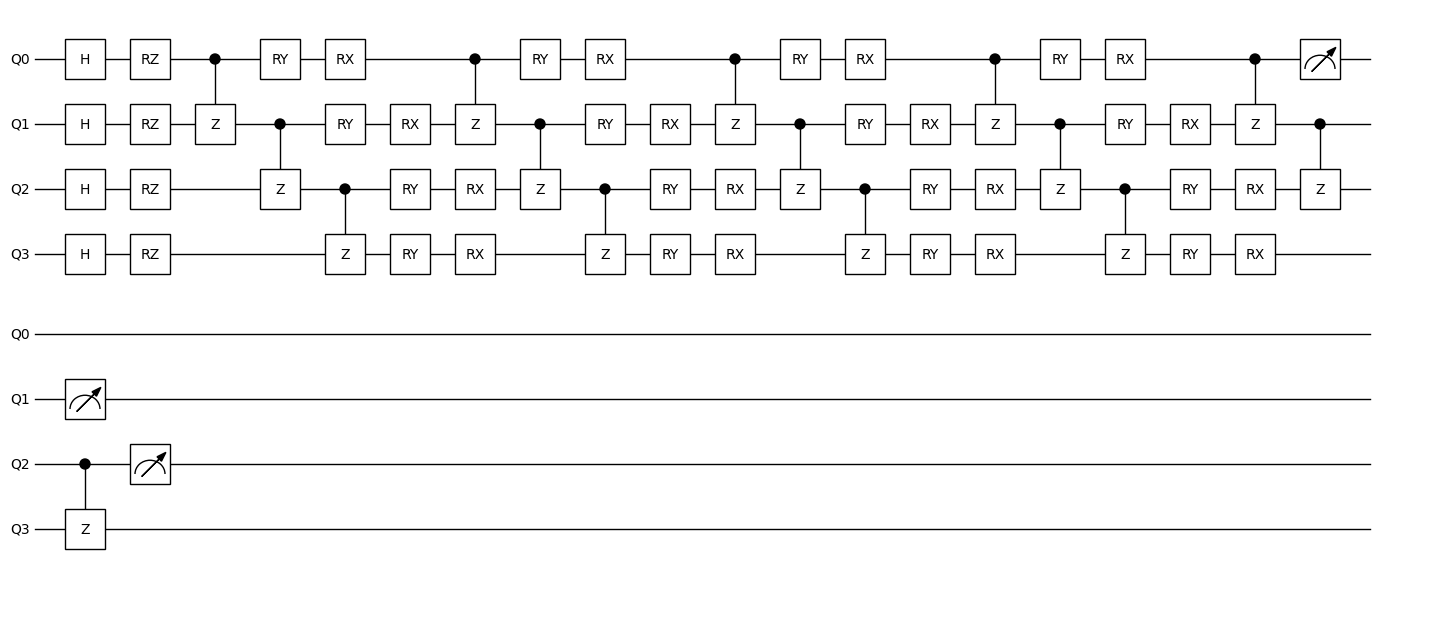

In [6]:
import tempfile
from pathlib import Path

from isqtools.draw import Drawer

backend = TorchBackend()
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "iris.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)
    qc = IsqCircuit(
        file=str(temp_file_path),
        backend=backend,
        sample=False,
    )


def circuit(inputs, weights):
    param = {
        "inputs": inputs,
        "weights": weights,
    }
    result = qc.measure(**param)
    feature1 = result[0].view(-1)
    feature2 = result[3].view(-1)
    feature3 = result[7].view(-1)
    features = torch.cat((feature1, feature2, feature3))
    return torch.softmax(features, dim=0)


qnn = TorchLayer(
    circuit=circuit,
    num_weights=32,
    is_vmap=True,
    in_dims=(0, None),
)

optimizer = torch.optim.Adam(qnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


dr = Drawer()
dr.plot(qc.qcis)

## Training

We train the quantum neural network for 1000 epochs. Thanks to `vmap` vectorization, the entire dataset (batch size = 150) can be processed in a single forward pass. For training implementation details, please refer to the PyTorch documentation.

During training, we record the loss and accuracy on the validation set throughout the entire process.

In [7]:
epochs = 1000
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
    y_pred = qnn(X_train)
    loss = loss_fn(y_pred, y_train)

    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = qnn(X_test)
        loss = loss_fn(y_pred, y_test)
        loss_list[epoch] = loss.item()
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 1000/1000 [00:15<00:00, 65.23it/s]


## Model Validation

After training, we visualize the final accuracy and loss on the validation set. The accuracy reaches 93%, indicating that the model achieves a good classification performance.

Final validation accuracy: 0.9333333373069763
Final validation loss: 0.9770382046699524


Text(0.5, 0, 'epochs')

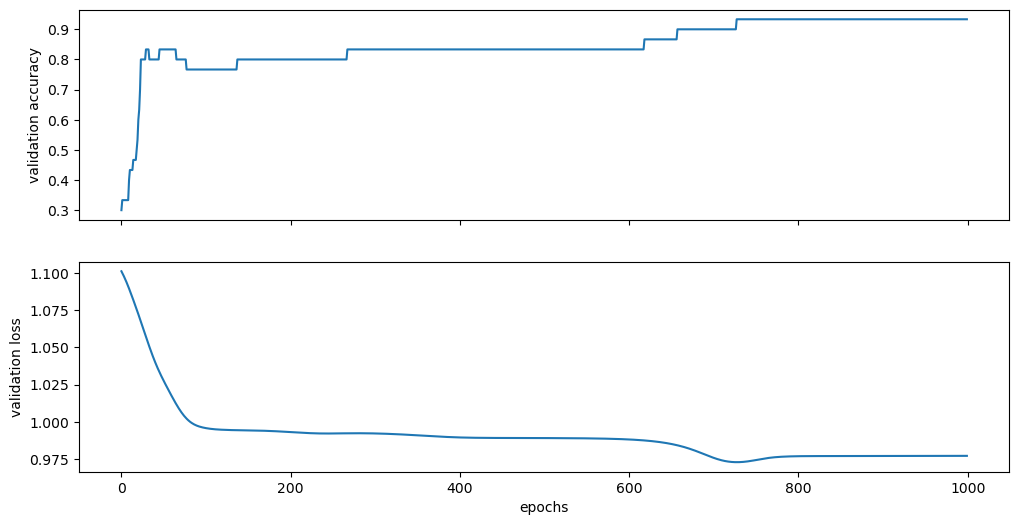

In [8]:
print("Final validation accuracy:", accuracy_list[-1])
print("Final validation loss:", loss_list[-1])

_, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

Finally, the quality of the model can be evaluated using the ROC (Receiver Operating Characteristic) curve. This curve illustrates the trade-off between the true positive rate and false positive rate across different classification thresholds, providing a more comprehensive assessment of the model’s performance, especially in multi-class or imbalanced scenarios.

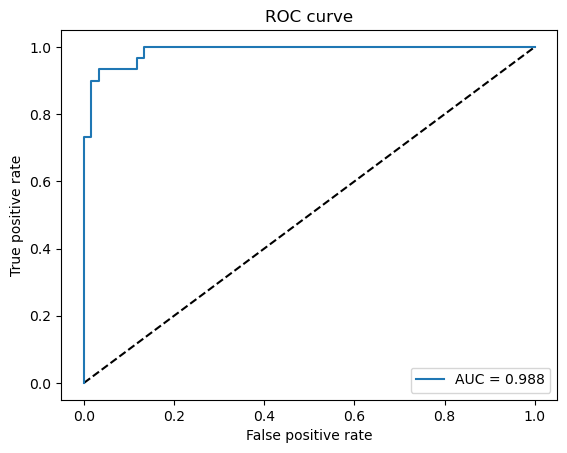

In [9]:
plt.plot([0, 1], [0, 1], "k--")

# One hot encoding
enc = preprocessing.OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = qnn(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, label="AUC = {:.3f}".format(auc(fpr, tpr)))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()

## Environment Information

The following versions of software and libraries are used in this tutorial:

In [10]:
import platform
import subprocess
from importlib.metadata import version

print(f"Python version used in this tutorial: {platform.python_version()}")
print(f"Execution environment: {platform.system()} {platform.release()}\n")


isqc_version = subprocess.check_output(
    ["isqc", "-V"], stderr=subprocess.STDOUT, text=True
).strip()
print(f"isqc version: {isqc_version}")

isqtools_version = version("isqtools")
print(f"isqtools version: {isqtools_version}")

numpy_version = version("numpy")
print(f"NumPy version: {isqtools_version}")

torch_version = version("torch")
print(f"Torch version: {torch_version}")

sklearn_version = version("scikit-learn")
print(f"scikit-learn version: {sklearn_version}")

Python version used in this tutorial: 3.13.5
Execution environment: Linux 6.12.41

isqc version: isQ Compiler 0.2.5
isqtools version: 1.3.0
NumPy version: 1.3.0
Torch version: 2.7.1
scikit-learn version: 1.6.1
